In [ ]:
#https://www.kaggle.com/saikumar587/imdb-text-classification-tf-idf-and-elmo

In [3]:
import glob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,HashingVectorizer
from sklearn import decomposition, ensemble
from sklearn.decomposition import PCA
import xgboost

import keras
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import string
import pandas as pd
from nltk.stem.porter import PorterStemmer
import re
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en import English
#spacy.load('en')
parser = English()

Using TensorFlow backend.
C:\Users\naray\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
#Load text files from train folder
pos_tran_files = glob.glob('C:\\Users\\naray\\Desktop\\imdb\\aclImdb\\train\\pos' + "/*.txt")
neg_train_files = glob.glob('C:\\Users\\naray\\Desktop\\imdb\\aclImdb\\train\\neg' + "/*.txt")

In [5]:
#read text files from train folder
pos_train_txt = []
pos_train_label = []
for txt in pos_tran_files:
    data = open(txt,encoding="utf-8").read()
    pos_train_txt.append(data)
    pos_train_label.append('pos')
    
neg_train_txt = []
neg_train_label = []
for txt in neg_train_files:
    data = open(txt,encoding="utf-8").read()
    neg_train_txt.append(data)
    neg_train_label.append('neg')

In [6]:
#Load text files from test folder
pos_test_files = glob.glob('C:\\Users\\naray\\Desktop\\imdb\\aclImdb\\test\\pos' + "/*.txt")
neg_test_files = glob.glob('C:\\Users\\naray\\Desktop\\imdb\\aclImdb\\test\\neg' + "/*.txt")

In [7]:
#read text files from test folder
pos_test_txt = []
pos_test_label = []
for txt in pos_test_files:
    data = open(txt,encoding="utf-8").read()
    pos_test_txt.append(data)
    pos_test_label.append('pos')
    
neg_test_txt = []
neg_test_label = []
for txt in neg_test_files:
    data = open(txt,encoding="utf-8").read()
    neg_test_txt.append(data)
    neg_test_label.append('neg')

In [8]:
# create train dataframe
train_pos_DF = pd.DataFrame()

train_pos_DF['text'] = pos_train_txt
train_pos_DF['label'] = pos_train_label

train_neg_DF = pd.DataFrame()

train_neg_DF['text'] = neg_train_txt
train_neg_DF['label'] = neg_train_label

trainDF = pd.concat([train_pos_DF,train_neg_DF])
trainDF = shuffle(trainDF)
trainDF = trainDF.reset_index(drop=True)

In [9]:
trainDF.head(3)

,text,label
0,"Alright, before we review, I have to ask: why ...",pos
1,"Black guy becomes rich white guy, and rich whi...",neg
2,This film illustrates the worst part of surviv...,pos


In [11]:
trainDF.shape

(10002, 2)

In [10]:
# create test dataframe
test_pos_DF = pd.DataFrame()

test_pos_DF['text'] = pos_test_txt
test_pos_DF['label'] = pos_test_label

test_neg_DF = pd.DataFrame()

test_neg_DF['text'] = neg_test_txt
test_neg_DF['label'] = neg_test_label

testDF = pd.concat([test_pos_DF,test_neg_DF])
testDF = shuffle(testDF)
testDF = testDF.reset_index(drop=True)

In [12]:
testDF.head(3)

,text,label
0,<br /><br />It sucked.<br /><br />I returned t...,neg
1,I was 13 when this mini-series (and its sequel...,pos
2,This is the worst waste of time I've ever expe...,neg


In [13]:
testDF.shape

(10002, 2)

In [17]:
trainDF['label'].unique()

array(['pos', 'neg'], dtype=object)

In [18]:
trainDF['label'].value_counts()

neg    5001
pos    5001
Name: label, dtype: int64

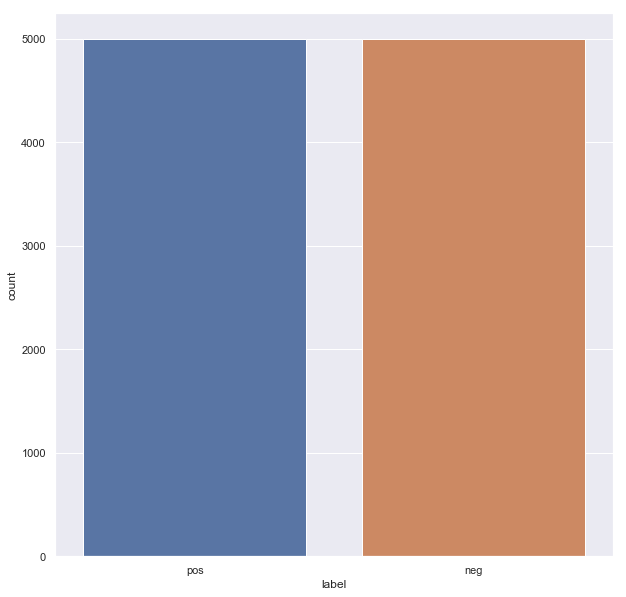

In [19]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(trainDF['label'])

In [31]:
# how spacy works - example
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be AUX VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP compound X.X. False False
startup startup NOUN NN dobj xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [30]:
# Data Preparation


['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '-', '...', '”', '”', "''"]


In [20]:
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

# Data Cleaner and tokenizer
def tokenizeText(text):
    
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    
    tokens = parser(text)
    
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # reomve stop words and special charaters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    tokens = [tok for tok in tokens if len(tok) >= 3]
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    # stemming of words
    #porter = PorterStemmer()
    #tokens = [porter.stem(word) for word in tokens]
    
    tokens = list(set(tokens))
    #return tokens
    return ' '.join(tokens[:])

In [21]:
# Data cleaning

trainDF['text'] = trainDF['text'].apply(lambda x:tokenizeText(x))
testDF['text'] = testDF['text'].apply(lambda x:tokenizeText(x))

In [22]:
# Data preparation
y_train = trainDF['label'].tolist()
x_train = trainDF['text'].tolist()

y_test = testDF['label'].tolist()
x_test = testDF['text'].tolist()

In [23]:
# Count Vectors as features
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train+x_test)

# transform the training and test data using count vectorizer object
xtrain_count =  count_vect.transform(x_train)
xtest_count =  count_vect.transform(x_test)

In [37]:
print(xtest_count[2])

  (0, 661)	1
  (0, 923)	1
  (0, 3324)	1
  (0, 5224)	1
  (0, 10467)	1
  (0, 13559)	1
  (0, 15332)	1
  (0, 19499)	1
  (0, 20252)	1
  (0, 20436)	1
  (0, 21438)	1
  (0, 23801)	1
  (0, 25303)	1
  (0, 26726)	1
  (0, 27017)	1
  (0, 27045)	1
  (0, 31684)	1
  (0, 31793)	1
  (0, 33031)	1
  (0, 33136)	1
  (0, 33149)	1
  (0, 33553)	1
  (0, 34478)	1
  (0, 35462)	1
  (0, 36150)	1
  :	:
  (0, 38789)	1
  (0, 42114)	1
  (0, 43189)	1
  (0, 43321)	1
  (0, 44152)	1
  (0, 46169)	1
  (0, 49460)	1
  (0, 50461)	1
  (0, 53097)	1
  (0, 54672)	1
  (0, 54686)	1
  (0, 56933)	1
  (0, 57417)	1
  (0, 57680)	1
  (0, 57747)	1
  (0, 58075)	1
  (0, 59064)	1
  (0, 62431)	1
  (0, 62447)	1
  (0, 62458)	1
  (0, 62530)	1
  (0, 62550)	1
  (0, 62760)	1
  (0, 63688)	1
  (0, 64156)	1


In [24]:
#model building

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    return metrics.accuracy_score(predictions, y_test)

In [25]:
# Naive Bayes on Count Vectors
accuracy = train_model(naive_bayes.MultinomialNB(), xtrain_count, y_train, xtest_count)
print("NB, Count Vectors: ", accuracy)

NB, Count Vectors:  0.8226354729054189


In [26]:
# Linear Classifier on Count Vectors
accuracy = train_model(linear_model.LogisticRegression(solver="lbfgs",multi_class="auto",max_iter=4000), xtrain_count, y_train, xtest_count)
print("LR, Count Vectors: ", accuracy)

LR, Count Vectors:  0.8484303139372126
